<a href="https://colab.research.google.com/github/mkandaleft/COMP432-GroupM/blob/main/Comp432.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [55]:
# Basic includes.
import numpy as np
import matplotlib.pyplot as plt
import sklearn
import torch
import torchvision
import random

# Do we need pandas, etc?

In [56]:
# Task specific includes.
import zipfile

# Download and unzip the first dataset.
!gdown 1ezX0lJaB8atZesMns4cGHR3pXkRTEKSt # Roxane: I put the dataset on my Drive for ease of downloading.

with zipfile.ZipFile("/content/Dataset1.zip", 'r') as zip_ref:
    zip_ref.extractall("/content")

data_path = "/content/Colorectal Cancer_"

Downloading...
From: https://drive.google.com/uc?id=1ezX0lJaB8atZesMns4cGHR3pXkRTEKSt
To: /content/Dataset1.zip
100% 814M/814M [00:10<00:00, 74.5MB/s]


In [57]:
# Load the data to a torch tensor.

# Code partly provided by the outline for assignment 1.
transforms = torchvision.transforms.Compose([torchvision.transforms.ToTensor(), torchvision.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

dataset = torchvision.datasets.ImageFolder(data_path, transforms) # loads dataset from path

# To do:


train_set, test_set = torch.utils.data.random_split(dataset, [0.7,0.3]) # splits dataset into specified ratios

batch_size = 100 # What batch size do we want?
train_loader = torch.utils.data.DataLoader(train_set, shuffle=True, batch_size=batch_size, num_workers=2) # create train loader
test_loader = torch.utils.data.DataLoader(test_set, shuffle=True, num_workers=2) # create test loader

torch.Size([3, 224, 224]) 0


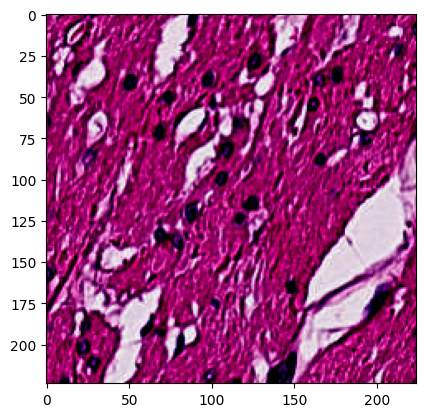

In [58]:
# Look at a random sample from the unprocessed training set.
index = random.randint(0, len(train_set))
image, label = train_set[index]
plt.imshow(image.numpy().transpose(1, 2, 0))
print(image.shape, label)

# Instead, print the same image before and after loading in the dataset?

# Preprocess the data.

# What do we need to do? Normalization, etc.
# Do we need to do data augmentation?



In [59]:
## Declare the model
# https://pytorch.org/vision/main/models/generated/torchvision.models.resnet18.html

resnet18 = torchvision.models.resnet18() # Do we need any special parameters?

In [60]:
# Train the model with the dataset.